In [4]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [5]:
##training for cmip6 models
dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'

models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CESM2-WACCM','CESM2','CIESM','CMCC-CM2-SR5','CNRM-CM6-1-HR','CNRM-CM6-1','CNRM-ESM2-1',
          'CanESM5','EC-Earth3-Veg','EC-Earth3','FGOALS-f3-L','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
         'INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MCM-UA-1-0','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR',
         'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']#CanESM5-CanOE,'IPSL-CM6A-LR'


#models=['IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','NorESM2-MM']
run_nrs={}
run_nrs['ACCESS-CM2']=[1,2]
run_nrs['ACCESS-ESM1-5']=[1,2,3,4,5,6,7]
run_nrs['AWI-CM-1-1-MR']=[1]
run_nrs['BCC-CSM2-MR']=[1]
run_nrs['CAMS-CSM1-0']=[1]
run_nrs['CESM2-WACCM']=[1,2]
run_nrs['CESM2']=[1,2,4]
run_nrs['CIESM']=[1]
run_nrs['CMCC-CM2-SR5']=[1]
run_nrs['CNRM-CM6-1-HR']=[1]
run_nrs['CNRM-CM6-1']=[1,2,3,4]
run_nrs['CNRM-ESM2-1']=[1,2,3]
run_nrs['CanESM5-CanOE']=[1,2]
run_nrs['CanESM5']=[1,2,3,4,5,6,7,8,9,10,11,12,13]
run_nrs['EC-Earth3-Veg']=[1,2,3]
run_nrs['EC-Earth3']=[1,4,6,9]
run_nrs['FGOALS-f3-L']=[1]
run_nrs['FGOALS-g3']=[1,2]
run_nrs['FIO-ESM-2-0']=[1,2]
run_nrs['GFDL-CM4']=[1]
run_nrs['GFDL-ESM4']=[1]
run_nrs['HadGEM3-GC31-LL']=[1,2]
run_nrs['HadGEM3-GC31-MM']=[1,2]
run_nrs['INM-CM4-8']=[1]
run_nrs['INM-CM5-0']=[1]
run_nrs['IPSL-CM6A-LR']=[1,2,3,4]
run_nrs['KACE-1-0-G']=[1,2]
run_nrs['KIOST-ESM']=[1]
run_nrs['MCM-UA-1-0']=[1]
run_nrs['MIROC-ES2L']=[1]
run_nrs['MIROC6']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
                   17,18,19,20,21,22,23,24,25]
run_nrs['MPI-ESM1-2-HR']=[1]
run_nrs['MPI-ESM1-2-LR']=[1,2,3,4,5,6,7]
run_nrs['MRI-ESM2-0']=[1]
run_nrs['NESM3']=[1]
run_nrs['NorESM2-LM']=[1]
run_nrs['NorESM2-MM']=[1]
run_nrs['TaiESM1']=[1]
run_nrs['UKESM1-0-LL']=[1,2,3]

test_run_nrs={}
test_run_nrs['ACCESS-CM2']=[3]
test_run_nrs['ACCESS-ESM1-5']=[8,9,10]
test_run_nrs['AWI-CM-1-1-MR']=[1]
test_run_nrs['BCC-CSM2-MR']=[1]
test_run_nrs['CAMS-CSM1-0']=[2]
test_run_nrs['CESM2-WACCM']=[3]
test_run_nrs['CESM2']=[10,11]
test_run_nrs['CIESM']=[1]
test_run_nrs['CMCC-CM2-SR5']=[1]
test_run_nrs['CNRM-CM6-1-HR']=[1]
test_run_nrs['CNRM-CM6-1']=[5,6]
test_run_nrs['CNRM-ESM2-1']=[4,5]
test_run_nrs['CanESM5-CanOE']=[3]
test_run_nrs['CanESM5']=[14,15,16,17,18,19,20,21,22,23,24,25]
test_run_nrs['EC-Earth3-Veg']=[4,6]
test_run_nrs['EC-Earth3']=[11,13,15]
test_run_nrs['FGOALS-f3-L']=[1]
test_run_nrs['FGOALS-g3']=[3,4]
test_run_nrs['FIO-ESM-2-0']=[3]
test_run_nrs['GFDL-CM4']=[1]
test_run_nrs['GFDL-ESM4']=[1]
test_run_nrs['HadGEM3-GC31-LL']=[3,4]
test_run_nrs['HadGEM3-GC31-MM']=[3]
test_run_nrs['INM-CM4-8']=[1]
test_run_nrs['INM-CM5-0']=[1]
test_run_nrs['IPSL-CM6A-LR']=[6,14]
test_run_nrs['KACE-1-0-G']=[3]
test_run_nrs['KIOST-ESM']=[1]
test_run_nrs['MCM-UA-1-0']=[1]
test_run_nrs['MIROC-ES2L']=[1]
test_run_nrs['MIROC6']=[26,27,28,29,30,
                   31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50]
test_run_nrs['MPI-ESM1-2-HR']=[2]
test_run_nrs['MPI-ESM1-2-LR']=[8,9,10]
test_run_nrs['MRI-ESM2-0']=[1]
test_run_nrs['NESM3']=[2]
test_run_nrs['NorESM2-LM']=[1]
test_run_nrs['NorESM2-MM']=[1]
test_run_nrs['TaiESM1']=[1]
test_run_nrs['UKESM1-0-LL']=[4,8]


In [6]:
## get cmip6 harmonic model results
train_results_all={}
test_results_all={}

Tanglob_wgt={}
y={}
time={}

y_mon={}
time_mon={}

y_all_mon_test={}
y_all_test={}

y_all_mon={}
y_all={}

seasonal_mod={}

for model in ['MPI-ESM1-2-LR']:
    
    #Get directory
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    print("Getting seasonal trends for" ,model)
    
    ##Get training values i.e. monthly/daily model run datas for selected models
    y_mon[model],time_mon[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l=load_data_single_mod(6,model,'ssp585',Tanglob_idx=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="mon")
    # T fields
    y[model],time[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tanglob_wgt[model]=load_data_single_mod(6,model,'ssp585',Tanglob_idx=True,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01')
    #Get model
    seasonal_mod[model]=joblib.load(dir_in_data_mod+'seasonal_trend.pkl')
    nr_ts = len(time[model]) #nr time steps (CAMS-CSM1-0 is 230, all others 231)
    
    ##get training data
    
    # prepare the inputs as array
    y_all[model] = np.zeros([nr_ts*len(run_nrs[model]),idx_l.sum()]) 
    y_all_mon[model] = np.zeros([12*nr_ts*len(run_nrs[model]),idx_l.sum()]) 

    i_mon=0
    i=0
    for run in run_nrs[model]:
        y_all[model][i:i+nr_ts]=y[model][run]
        y_all_mon[model][i_mon:i_mon+(nr_ts*12)]=y_mon[model][run][:12*nr_ts]
        i_mon+=(nr_ts*12)
        i+=nr_ts

    train_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')

    
        

    ###############Get test set too#####################################
    
    y_all_mon_test[model] = np.zeros([12*nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 
    y_all_test[model] = np.zeros([nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 

    i=0
    i_mon=0
    for run in test_run_nrs[model]:
        y_all_test[model][i:i+nr_ts]=y[model][run]
        y_all_mon_test[model][i_mon:i_mon+(12*nr_ts)]=y_mon[model][run][:12*nr_ts]
        i+=nr_ts
        i_mon+=12*nr_ts


    test_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_test_results.pkl')

        

Getting seasonal trends for MPI-ESM1-2-LR
start with model MPI-ESM1-2-LR


/home/snath/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).Th

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

In [87]:
y_all_mon.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CESM2', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-Veg', 'EC-Earth3', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL', 'CESM1-CAM5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'EC-EARTH'])

In [9]:
## Making box plots of pearson correlations
## statistics
from scipy.stats import pearsonr

corr_te = np.full([len(models),12],np.nan)
corr_emu = np.full([len(models),12],np.nan)
labels=[]

i_mod=0
for model in tqdm(models):
    
    print('Calculating pearson correlations for: ',model)
    
    for i_mon in range(12):
    
        nr_ts=len(time[model])

        if 1 not in test_run_nrs[model]:

            #i_temp=0
            #for run in run_nrs[model]:
                #for run_te in test_run_nrs[model]:

            corr_te[i_mod,i_mon] = pearsonr(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten(),
                                 test_results_all[model].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten())[0]#pearsonr(y_mon[model][run][:12*nr_ts].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten(),
                                                   #  y_mon[model][run_te][:12*nr_ts].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten())[0]

            #        i_temp+=1

            labels.append('%s(%i)'%(model,len(test_run_nrs[model])))
        else:
            labels.append('%s'%(model))


        corr_emu[i_mod,i_mon] = pearsonr(y_all_mon[model].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten(),
                                              train_results_all[model].reshape(-1,12,idx_l.sum())[:,i_mon,:].flatten())[0]

    i_mod+=1
        
    
            
    


Calculating pearson correlations for:  CESM1-CAM5
Calculating pearson correlations for:  MPI-ESM-LR
Calculating pearson correlations for:  MPI-ESM-MR
Calculating pearson correlations for:  EC-EARTH
Calculating pearson correlations for:  ACCESS-CM2
Calculating pearson correlations for:  ACCESS-ESM1-5
Calculating pearson correlations for:  AWI-CM-1-1-MR
Calculating pearson correlations for:  BCC-CSM2-MR
Calculating pearson correlations for:  CAMS-CSM1-0
Calculating pearson correlations for:  CESM2-WACCM
Calculating pearson correlations for:  CESM2
Calculating pearson correlations for:  CIESM
Calculating pearson correlations for:  CMCC-CM2-SR5
Calculating pearson correlations for:  CNRM-CM6-1-HR
Calculating pearson correlations for:  CNRM-CM6-1
Calculating pearson correlations for:  CNRM-ESM2-1
Calculating pearson correlations for:  CanESM5
Calculating pearson correlations for:  EC-Earth3-Veg
Calculating pearson correlations for:  EC-Earth3
Calculating pearson correlations for:  FGOALS-f3

In [24]:
dir_out_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

if not os.path.exists(dir_out_data_mod):
    os.makedirs(dir_out_data_mod)
    print('created dir:',dir_out_data_mod)
    
joblib.dump(corr_te,dir_out_data_mod+'mean_response_corr_test_monthly.pkl')
joblib.dump(corr_emu,dir_out_data_mod+'mean_response_corr_emu_monthly.pkl')

labs=[]
for lab in labels:
    if lab not in labs:
        labs.append(lab)
joblib.dump(labs,dir_out_data_mod+'labels.pkl')


['/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/labels.pkl']

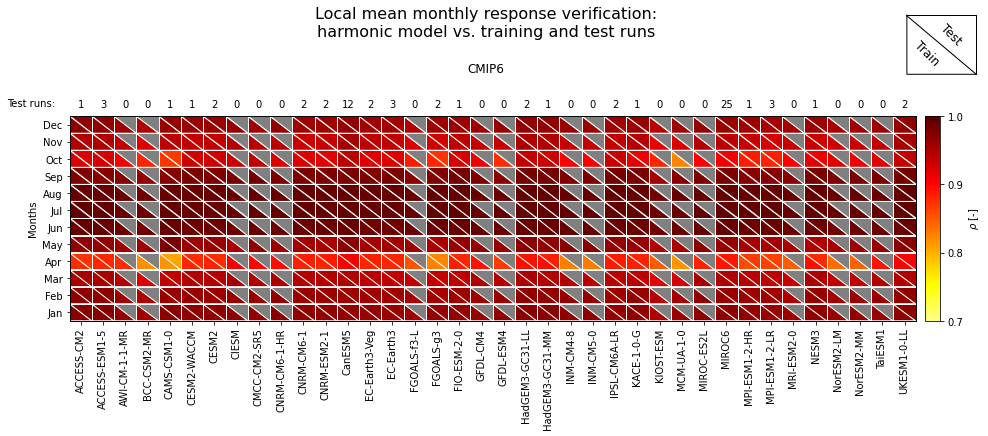

In [30]:
from matplotlib.tri import Triangulation
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'
single=False
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

import matplotlib as mpl
''' plotting single month'''
labels=joblib.load(dir_in_data_mod+'labels.pkl')
if single:
    corr_te=joblib.load(dir_in_data_mod+'mean_response_corr_test.pkl')
    corr_emu=joblib.load(dir_in_data_mod+'mean_response_corr_emu.pkl')
    fs_title=16

    n_row = 9

    #plt.figure(figsize=(12, n_row * 1.2))
    plt.figure(figsize=(12, n_row * 1.2))

    plt.rcParams.update({'font.size': 10})
    #plt.rcParams.update({'mathtext.default':'regular'}) 
    plt.rcParams.update({'mathtext.default':'it'}) 


    #grid = plt.GridSpec(n_row*7+6, 81, wspace=0, hspace=0.15) # create a grid for the subplots #0.12
    grid = plt.GridSpec(n_row*7+8, 83, wspace=0, hspace=0.15) # create a grid for the subplots #0.12

    xticks= np.arange(1,len(models)+1)

    # Global deterministic response
    axtitle = plt.subplot(grid[0,:-1])
    plt.title('Local trend verification:\n'+r'harmonic model vs. training and test runs',y=-0,fontsize=fs_title)
    plt.axis('off')

    ax1=plt.subplot(grid[1:7,:-1])
    plt.bar(xticks,corr_emu,color='lightgrey',zorder=0)
    for i in np.arange(corr_te.shape[1]):
        plt.scatter(xticks,corr_te[:,i],marker='x',color='k')

    plt.ylim([0,1.1])
    plt.ylabel('r [-]')
    xk=plt.xticks(np.arange(1,len(models)+1), labels, rotation='vertical')
    plt.xlim([0.4,41.6])


else:
    '''plotting multiple months'''
    
    fs_title=16
    corr_te=joblib.load(dir_in_data_mod+'mean_response_corr_test_monthly.pkl')
    corr_emu=joblib.load(dir_in_data_mod+'mean_response_corr_emu_monthly.pkl')
    labels=joblib.load(dir_in_data_mod+'labels.pkl')
    
    test_label=[]
    label_act=[]
    for i in labels:
        try:
            test_label.append(i.split('(')[1].split(')')[0])
            label_act.append(i.split('(')[0])
        except:
            label_act.append(i)
            test_label.append('0')
    
    xlabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    n_row = 12

    
    colors = plt.cm.hot_r(np.linspace(0, 1, 256))[30:-30]


    colors = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)
    
    norm = mpl.colors.Normalize(vmin=0.7, vmax=1)
    
    plt.figure(figsize=(17, n_row * 4 + 9))

    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'mathtext.default':'it'}) 


    grid = plt.GridSpec(n_row*7+5, 74, wspace=0, hspace=0.15) # create a grid for the subplots #0.12

      
    
    '''CMIP6'''
    
    ax1=plt.subplot(grid[3:9,1:-7])
    
    M = len(labels)-4
    N = 12
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)

    pearson_mesh_plot = np.zeros([12,len(labels)-4])
    pearson_mesh_plot_te = np.zeros([12,len(labels)-4])
    
    triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
    
    xticks = np.arange(len(labels)-4)+0.5
    for i_mon in range(12):
        pearson_mesh_plot[i_mon,:] = corr_emu[4:,i_mon]
        pearson_mesh_plot_te[i_mon,:]=corr_te[4:,i_mon]
        
    tri_mesh_1 = plt.tripcolor(triang1, pearson_mesh_plot.ravel(),cmap=colors,edgecolors='w',linewidth=1,vmin=0.7,vmax=1)
    tri_mesh_2 = plt.tripcolor(triang2, pearson_mesh_plot_te.ravel(),cmap=colors,edgecolors='w',linewidth=1,vmin=0.7,vmax=1)
    cmap_mesh=tri_mesh_2.get_cmap()
    cmap_mesh.set_bad('grey')

    
    ax1.set_xticks(xticks)
    ax1.set_xlim(0,len(labels)-4)
    ax1.set_xticklabels(label_act[4:],rotation=90)

    ax1.set_yticks(np.arange(12)+0.5)
    ax1.set_ylim(0,12)
    ax1.set_yticklabels(months)
    ax1.set_ylabel('Months')
    
    
    ax2 = ax1.twiny()
    ax2.set_xlim(0,len(labels)-4)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(test_label[4:])
    ax2.tick_params(axis='x', which = "both", bottom = False, top = False, labelsize=10)

    
    sm = mpl.cm.ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])
    axcbar = plt.subplot(grid[3:9,-5])
    cbar=plt.colorbar(sm, orientation='vertical',ticks=np.arange(7,11)/10,fraction=2.3, aspect=13)
    cbar.set_label(r"$\rho$ [-]")
    plt.axis('off')
    
   
    axtitle = plt.subplot(grid[1,1:-8])
    plt.title('CMIP6',y=-0.05,fontsize=12)
    plt.axis('off')
    
    axtitle = plt.subplot(grid[2,0])
    plt.title('Test runs:',y=-0.02,x=-2,fontsize=10)
    plt.axis('off')
       
    axleg = plt.subplot(grid[:2,-8:-2])
    M = 1
    N = 1
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)

    pearson_mesh_plot = np.zeros([1,1])
    
    triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
    tri_mesh_1 = plt.tripcolor(triang1, pearson_mesh_plot.ravel(),cmap='Greys',edgecolors='k',linewidth=1)
    tri_mesh_2 = plt.tripcolor(triang2, pearson_mesh_plot.ravel(),cmap='Greys',edgecolors='k',linewidth=1)
    plt.text(0.08,0.15,'Train',rotation=-45,fontsize=12)
    #plt.text(0.5,0.6,r'ESM',rotation=-45)
    plt.text(0.45,0.5,r'Test',rotation=-45,fontsize=12)
    

    #plt.legend(handles=legend_elements, loc='center',prop={'size': 10})
    plt.axis('off')
    
    axtitle = plt.subplot(grid[0,1:-8])
    plt.title('Local mean monthly response verification:\n'+r'harmonic model vs. training and test runs',y=-0,fontsize=fs_title)
    plt.axis('off')
    
    plt.savefig('/net/so4/landclim/snath/loc_trend_veri.pdf', dpi=300)
  


In [11]:
import geopandas

dir_srex_shape='/net/so4/landclim/snath/data/referenceRegions.shp'

df_all_regs = geopandas.read_file(dir_srex_shape)
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] # SREX names ordered according to SREX mask I am 
              
df_srex = df_all_regs.loc[df_all_regs['LAB'].isin(srex_names)] # alternative indexing: search in column LAB for names


In [11]:
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

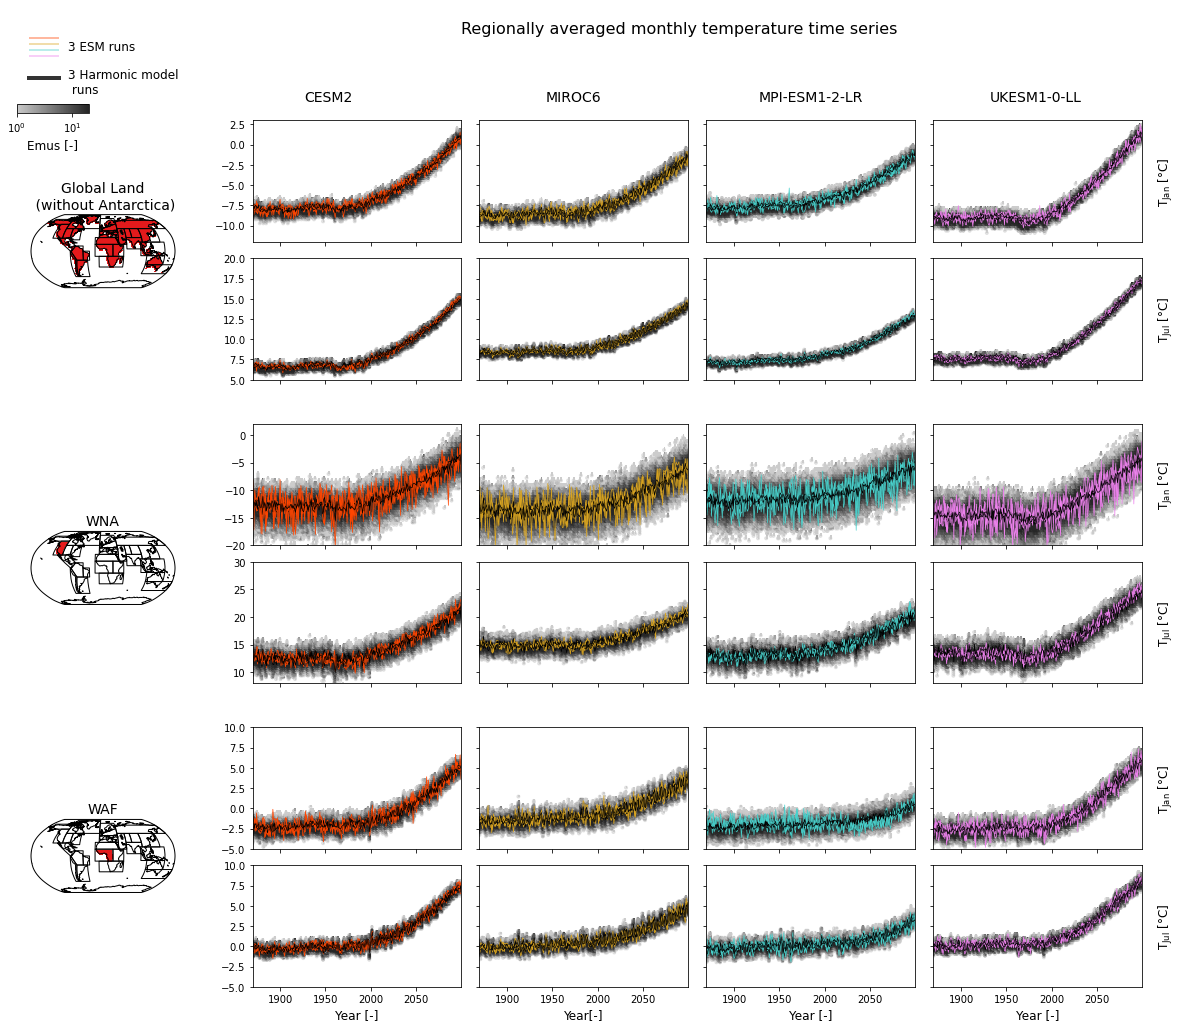

In [24]:
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import LogNorm, Normalize,LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import LogFormatter

def plt_2Dhist(times,mod,emu,nr_ts,model):
    
    colors = plt.cm.gist_gray_r(np.linspace(0, 1, 100))[20:-15]
    colors = LinearSegmentedColormap.from_list('my_colormap', colors)

    x_emu=np.tile(times,emu.shape[0])
    
    extent_y=np.linspace(np.vstack((mod,emu)).min(),np.vstack((mod,emu)).max()+0.1,50)
    
    if model=='CESM2':
        cm='autumn'
    elif model=='MIROC6':
        cm='spring'
    elif model=='MPI-ESM1-2-LR':
        cm='cool'
    elif model=='UKESM1-0-LL':
        cm=LinearSegmentedColormap.from_list('my_colormap', plt.cm.spring_r(np.linspace(0, 1, 100))[20:-5])
    density,x_edges,y_edges,_=plt.hist2d(x_emu.flatten(),emu.flatten(),bins=[np.unique(x_emu)-0.5,extent_y],norm=LogNorm(),cmap=colors,vmin=1,vmax=10,alpha=1,rasterized=True,zorder=1)
    X,Y=np.meshgrid(x_edges[:-1],y_edges[:-1])
    im=plt.scatter(X.flatten(),Y.flatten(),s=9,c=density.flatten(order='F'),norm=LogNorm(),cmap=colors,vmin=1,vmax=20,alpha=0.5,edgecolors=None)
    
    return im

v_srex=np.array([-0.5,0.5,1.5])
cmap_srex, norm_srex = from_levels_and_colors(v_srex, colors=['white','#e41a1c'], extend='neither')
srex = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)


fig=plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 

fs_title=16


grid = plt.GridSpec(6*5+10, 10, wspace=0.2, hspace=1.5) # create a grid for the subplots

axESM1 = plt.subplot(grid[0,1:3])
plt.text(y=0.2,x=0.25,s='CESM2',fontsize=fs_title-2)
plt.axis('off')


axESM2 = plt.subplot(grid[0,3:4])
plt.text(y=0.2,x=0.7,s='MIROC6',fontsize=fs_title-2)
plt.axis('off')

axESM3 = plt.subplot(grid[0,5:7])
plt.text(y=0.2,x=0.25,s='MPI-ESM1-2-LR',fontsize=fs_title-2)
plt.axis('off')

axESM4 = plt.subplot(grid[0,7:8])
plt.text(y=0.2,x=0.6,s='UKESM1-0-LL',fontsize=fs_title-2)
plt.axis('off')

wgt=wgt_l
i=1
model='CESM2'
plt.subplot(grid[i:i+5,1:3])

plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,0,:],axis=2,weights=wgt),nr_ts,model)

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)


plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-12,3)
plt.subplot(grid[i+5:i+10,1:3])

plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,6,:],axis=2,weights=wgt),nr_ts,model)    

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(5,20)


model='MIROC6'
plt.subplot(grid[i:i+5,3:5])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,0,:],axis=2,weights=wgt),nr_ts,model)

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)


plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-12,3)

plt.subplot(grid[i+5:i+10,3:5])
i_run=0
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,6,:],axis=2,weights=wgt),nr_ts,model)

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(5,20)

model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,0,:],axis=2,weights=wgt),nr_ts,model)

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,0,:],axis=2,weights=wgt),nr_ts,model)
    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-12,3)

plt.subplot(grid[i+5:i+10,5:7])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,6,:],axis=2,weights=wgt),nr_ts,model)
for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(5,20)

model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,0,:],axis=2,weights=wgt),nr_ts,model)

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_label_position('right')
plt.ylim(-12,3)
plt.ylabel(r'$T_{Jan}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)

plt.subplot(grid[i+5:i+10,7:9])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,:],axis=2,weights=wgt),
                                              np.average(full_emu[model][:,:,6,:],axis=2,weights=wgt),nr_ts,model)

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,:],axis=1,weights=wgt),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_label_position('right')
plt.ylim(5,20)
plt.ylabel(r'$T_{Jul}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)
idx_reg_l_grid = idx_l
ax_sub = fig.add_axes([0.05, 0.72, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('Global Land\n (without Antarctica)', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)

reg='WNA' 
idx_reg = srex_names.index(reg)+1 # index region
idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l

i=12
model='CESM2'
plt.subplot(grid[i:i+5,1:3])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-20,2)

plt.subplot(grid[i+5:i+10,1:3])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)
    

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(8,30)


model='MIROC6'
plt.subplot(grid[i:i+5,3:5])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                            np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)
    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-20,2)
plt.subplot(grid[i+5:i+10,3:5])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(8,30)

model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])

plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)
    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-20,2)

plt.subplot(grid[i+5:i+10,5:7])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)
    
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(8,30)

model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                             np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-20,2)
plt.gca().yaxis.set_label_position('right')
plt.ylabel(r'$T_{Jan}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)

plt.subplot(grid[i+5:i+10,7:9])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                            np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().yaxis.set_label_position('right')
plt.ylim(8,30)
plt.ylabel(r'$T_{Jul}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())

ax_sub = fig.add_axes([0.05, 0.5, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('WNA', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)


reg='WAF'
idx_reg = srex_names.index(reg)+1 # index region
idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l

i=23
model='CESM2'
plt.subplot(grid[i:i+5,1:3])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)


plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)

plt.subplot(grid[i+5:i+10,1:3])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='orangered',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.ylim(-5,10)
plt.xlabel('Year [-]', fontsize=12)

model='MIROC6'
plt.subplot(grid[i:i+5,3:5])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)

plt.subplot(grid[i+5:i+10,3:5])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run,_ in enumerate(run_nrs[model][:3]):
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='goldenrod',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)
plt.xlabel('Year[-]', fontsize=12)


model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                             np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    


for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)

plt.subplot(grid[i+5:i+10,5:7])

plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='mediumturquoise',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)
plt.xlabel('Year [-]', fontsize=12)


model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
#plt.plot(time[model],np.average(full_emu[model][:150,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]).T,lw=0.7,color='gray')
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,0,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,0,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)
plt.gca().yaxis.set_label_position('right')
plt.ylabel(r'$T_{Jan}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)

plt.subplot(grid[i+5:i+10,7:9])
#plt.plot(time[model],np.average(full_emu[model][:150,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]).T,lw=0.7,color='gray')
plt_2Dhist(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),
                                              np.average(full_emu[model][:,:,6,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),nr_ts,model)    

for run in run_nrs[model][:3]:
    run=run-1
    plt.plot(time[model],np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='violet',alpha=1,lw=0.7)
    plt.plot(time[model],np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,6,idx_reg_l].T,axis=1,weights=wgt[idx_reg_l]),color='k',lw=0.7,alpha=1)

plt.gca().yaxis.set_label_position('right')
plt.ylabel(r'$T_{Jul}$ [$\degree C$]',rotation=90,labelpad=15, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(-5,10)
plt.xlabel('Year [-]', fontsize=12)

ax_sub = fig.add_axes([0.05, 0.3, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('WAF', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)


    
colors = ['orangered','goldenrod','mediumturquoise','violet']
styles = ['solid','solid','solid','solid']
line = [[(0, 0)]]
# set up the proxy artist
lc = mcol.LineCollection(4 * line, linestyles=styles, colors=colors, alpha=0.5)
legend_elements = [Line2D([0], [0], color='k', alpha=0.8,lw=4)]

axlegend=fig.add_axes([0.11, 0.83, 0.05, 0.1])
plt.legend([lc,legend_elements[0]], ['3 ESM runs','3 Harmonic model\n runs'],handler_map={type(lc): HandlerDashedLines()},
           handlelength=2.5, handleheight=3.5,frameon=False,fontsize=12)

plt.axis('off')
         
colors = plt.cm.gist_gray_r(np.linspace(0, 1, 100))[20:-15]
colors = LinearSegmentedColormap.from_list('my_colormap', colors)
sm = plt.cm.ScalarMappable(cmap=colors, norm=LogNorm(vmin=1,vmax=20))
axcbar = fig.add_axes([0.04, 0.86, 0.05, 0.08])
formatter = LogFormatter(10, labelOnlyBase=True)
cbar=plt.colorbar(sm,orientation='horizontal',ticks=[1,10],aspect=8)
cbar.set_label("Emus [-]", fontsize=12)


plt.axis('off') 


plt.suptitle('Regionally averaged monthly temperature time series',fontsize=fs_title,y=0.93,x=0.5)
plt.savefig('/net/so4/landclim/snath/hm_esm_emu_reg_temp_ts.pdf', dpi=500)


In [9]:
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import LogNorm, Normalize,LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import LogFormatter

def draw_brace(ax, xspan, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    ymin=ymin+0.6
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:resolution//2+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = ymin + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(y,x, color='black', lw=1,zorder=10)

    ax.text(ymin+.12*yspan, (xmax+xmin)/2.-0.08,text, ha='left', va='bottom',zorder=10,fontsize=12)

In [ ]:
def plt_2Dhist(x_emu,emu,space=0.5):
    
    colors = plt.cm.gist_gray_r(np.linspace(0, 1, 100))[20:-15]
    colors = LinearSegmentedColormap.from_list('my_colormap', colors)
    
    extent_x=np.linspace(x_emu.min(),x_emu.max()+0.1,50)
    extent_y=np.linspace(emu.min(),emu.max()+0.1,30)
    
    density,x_edges,y_edges,_=plt.hist2d(x_emu.flatten(),emu.flatten(),bins=[extent_x,extent_y],norm=LogNorm(),cmap=colors,vmin=1,vmax=10,alpha=1,rasterized=True,zorder=1)  
    X,Y=np.meshgrid(x_edges[:-1],y_edges[:-1])
    #print(x_edges.shape, y_edges.shape, density.shape)
    im=plt.scatter(X.flatten(),Y.flatten(),s=49,c=density.flatten(order='F'),norm=LogNorm(),cmap=colors,vmin=1,vmax=20,alpha=0.5,edgecolors=None)

    return im


from matplotlib.colors import from_levels_and_colors
v_srex=np.array([-0.5,0.5,1.5])
cmap_srex, norm_srex = from_levels_and_colors(v_srex, colors=['white','#e41a1c'], extend='neither')
srex = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)


fig=plt.figure(figsize=(20, 13))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 

fs_title=16


grid = plt.GridSpec(3*5+10, 10, wspace=0.2, hspace=1.5) # create a grid for the subplots

axESM1 = plt.subplot(grid[0,1:3])
plt.text(y=0.2,x=0.25,s='CESM2',fontsize=fs_title-2)
plt.axis('off')


axESM2 = plt.subplot(grid[0,3:4])
plt.text(y=0.2,x=0.7,s='MIROC6',fontsize=fs_title-2)
plt.axis('off')

axESM3 = plt.subplot(grid[0,5:7])
plt.text(y=0.2,x=0.25,s='MPI-ESM1-2-LR',fontsize=fs_title-2)
plt.axis('off')

axESM4 = plt.subplot(grid[0,7:8])
plt.text(y=0.2,x=0.6,s='UKESM1-0-LL',fontsize=fs_title-2)
plt.axis('off')

wgt=wgt_l
i=1
model='CESM2'
plt.subplot(grid[i:i+5,1:3])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,:],axis=2,weights=wgt),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,:],axis=3,weights=wgt),axis=2).reshape(-1))
for run,_ in enumerate(run_nrs[model][:3]):
    #run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='orangered',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(20,45)
plt.xlim(-2,11.1)
plt.xticks([0,5,10])
model='MIROC6'
plt.subplot(grid[i:i+5,3:5])

plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,:],axis=2,weights=wgt),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,:],axis=3,weights=wgt),axis=2).reshape(-1))

for run,_ in enumerate(run_nrs[model][:3]):
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='goldenrod',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(20,45)
plt.xlim(-2,11.1)
plt.xticks([0,5,10])
model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,:],axis=2,weights=wgt),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,:],axis=3,weights=wgt),axis=2).reshape(-1))
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='mediumturquoise',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(20,45)
plt.xlim(-2,11.1)
plt.xticks([0,5,10])
model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,:],axis=2,weights=wgt),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,:],axis=3,weights=wgt),axis=2).reshape(-1))
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='violet',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,:],axis=1,weights=wgt),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,:],axis=2,weights=wgt),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_label_position('right')
plt.ylim(20,45)
plt.xlim(-2,11.1)
plt.xticks([0,5,10])
#plt.ylabel(r'Var($T_{Jan-Dec})$',rotation=0,labelpad=45)
idx_reg_l_grid = idx_l

ax_sub = fig.add_axes([0.05, 0.73, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('Global Land\n (without Antarctica)', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)

reg='WNA' 
idx_reg = srex_names.index(reg)+1 # index region
idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l

i=7
model='CESM2'
plt.subplot(grid[i:i+5,1:3])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),1)

for run,_ in enumerate(run_nrs[model][:3]):
    #run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='orangered',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(40,160)
plt.xlim(-4.1,12.1)
plt.xticks([0,5,10])
model='MIROC6'
plt.subplot(grid[i:i+5,3:5])

plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),1)
for run,_ in enumerate(run_nrs[model][:3]):
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='goldenrod',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(40,160)
plt.xlim(-4.1,12.1)
plt.xticks([0,5,10])
model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),1)
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='mediumturquoise',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(40,160)
plt.xlim(-4.1,12.1)
plt.xticks([0,5,10])
model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),1)
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='violet',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
#plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_label_position('right')
plt.ylabel(r'Intra-annual temperature variance [$(\degree C)^2$]',labelpad=45, rotation=90, fontsize=15)
plt.ylim(40,160)
plt.xlim(-4.1,12.1)
plt.xticks([0,5,10])

ax_sub = fig.add_axes([0.05, 0.55, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('WNA', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)



reg='WAF'
idx_reg = srex_names.index(reg)+1 # index region
idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l

i=13
model='CESM2'
plt.subplot(grid[i:i+5,1:3])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),0.1)
for run,_ in enumerate(run_nrs[model][:3]):
    #run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='orangered',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
plt.ylim(0,7)
plt.xlim(-1.5,9)
plt.xticks([0,4,8])

model='MIROC6'
plt.subplot(grid[i:i+5,3:5])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),0.1)
for run,_ in enumerate(run_nrs[model][:3]):
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='goldenrod',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')

plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(0,7)
plt.xlim(-1.5,9)
plt.xticks([0,4,8])

model='MPI-ESM1-2-LR'
plt.subplot(grid[i:i+5,5:7])

plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),0.1)
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='mediumturquoise',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim(0,7)
plt.xlim(-1.5,9)
plt.xticks([0,4,8])

model='UKESM1-0-LL'
plt.subplot(grid[i:i+5,7:9])
plt_2Dhist(np.repeat(np.average(y_all[model].reshape(len(run_nrs[model]),nr_ts,idx_l.sum())[:3,:,idx_reg_l],axis=2,weights=wgt[idx_reg_l]),50,axis=0).reshape(-1),
            np.nanvar(np.average(full_emu[model][:150,:,:,idx_reg_l],axis=3,weights=wgt[idx_reg_l]),axis=2).reshape(-1),0.1)
for run in run_nrs[model][:3]:
    run=run-1
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='violet',alpha=0.3)
    plt.scatter(np.average(y_all[model][run*nr_ts:run*nr_ts+nr_ts,idx_reg_l],axis=1,weights=wgt[idx_reg_l]),np.nanvar(np.average(train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,:,idx_reg_l],axis=0,weights=wgt[idx_reg_l]),axis=1),color='k')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_label_position('right')
#plt.ylabel(r'Var($T_{Jan-Dec})$',rotation=0,labelpad=45)
plt.ylim(0,7)
plt.xlim(-1.5,9)
plt.xticks([0,4,8])

ax_xlabel=plt.subplot(grid[i+6,4:6])
ax_xlabel.set_title(r'Yearly temperature [$\degree C$]', fontsize=15)
plt.axis('off')

ax_sub = fig.add_axes([0.05, 0.38, 0.1, 0.1],projection=ccrs.Robinson(central_longitude=0))
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax_sub.coastlines()
ax_sub.set_title('WAF', fontsize=14)
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_reg_l_grid, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)

legend_elements = [Line2D([0], [0], marker='o',color='orangered', alpha=0.8,lw=0),
                  Line2D([0], [0], marker='o',color='goldenrod', alpha=0.8,lw=0),
                  Line2D([0], [0], marker='o',color='mediumturquoise',alpha=0.8, lw=0),
                  Line2D([0], [0], marker='o',color='violet',alpha=0.8, lw=0),
                  Line2D([0], [0], marker='o',color='k', alpha=0.8,lw=0)]

axlegend=fig.add_axes([0.03, 0.85, 0.1, 0.1])
plt.legend(legend_elements[:4], ['','','',''],loc='center',frameon=False)

plt.axis('off')

draw_brace(axlegend,(0.19,0.86),'3 ESM\n runs')
axlegend=fig.add_axes([0.13, 0.86, 0.1, 0.1])
legend=plt.legend([legend_elements[-1]], ['3 Harmonic\n model runs'],loc='center',frameon=False,fontsize=12)
colors = plt.cm.gist_gray_r(np.linspace(0, 1, 100))[20:-15]
colors = LinearSegmentedColormap.from_list('my_colormap', colors)
sm = plt.cm.ScalarMappable(cmap=colors, norm=LogNorm(vmin=1,vmax=20))
plt.axis('off')
axcbar = fig.add_axes([0.14, 0.88, 0.05, 0.06])
formatter = LogFormatter(10, labelOnlyBase=True)
cbar=plt.colorbar(sm,orientation='horizontal',ticks=[1,10],aspect=8)
cbar.set_label("Emus [-]", fontsize=10,labelpad=-8,x=0.35)


plt.axis('off')
plt.suptitle('Regionally averaged variance of intra-annual temperatures vs yearly temperatures',fontsize=fs_title,y=0.95,x=0.5)
plt.savefig('/net/so4/landclim/snath/hm_esm_emu_reg_temp_var.pdf', dpi=300)
plt.savefig('/net/so4/landclim/snath/hm_esm_emu_reg_temp_var.png', dpi=300)

# Plotting sel model properties

In [16]:
def get_yeo_johnson_lambdas(coeffs,y):

    lambdas=np.zeros_like(y)
    i=0
    for a,b in zip(coeffs,y.T):
        
        lambdas[:,i]=2/(1+a[0]*np.exp(b*a[1]))
        i+=1
        
    lambdas=np.where(lambdas<0,0,lambdas)
    lambdas=np.where(lambdas>2,2,lambdas)
    
    return lambdas
        

# Plot model calibration results

In [20]:
lat_pc=np.array([-90. , -87.5, -85. , -82.5, -80. , -77.5, -75. , -72.5, -70. ,
       -67.5, -65. , -62.5, -60. , -57.5, -55. , -52.5, -50. , -47.5,
       -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. ,
       -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,
         0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ], dtype=np.float32)

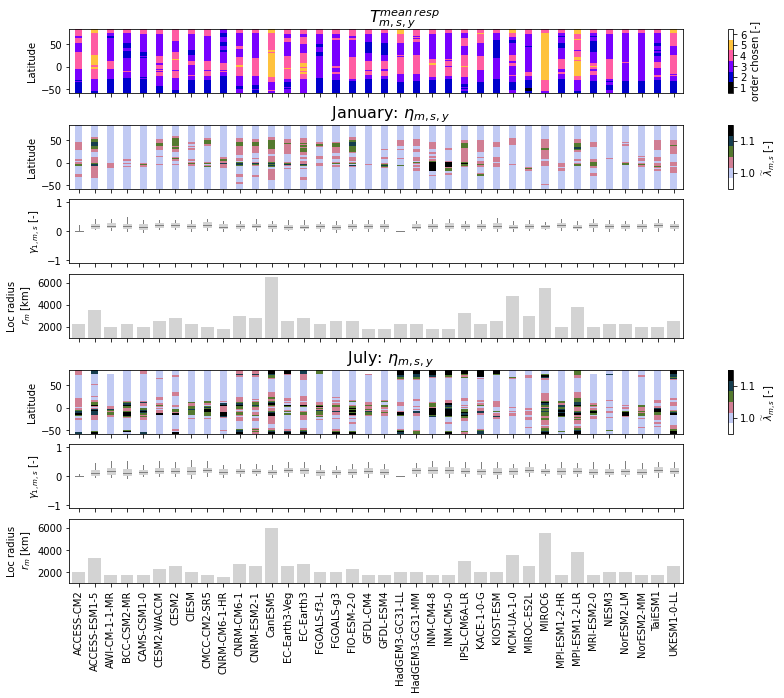

In [21]:
import matplotlib as mpl
n_col = 4
n_row = 11

fs_title=16

plt.figure(figsize=(n_col*3, n_row * 1.8))
plt.rcParams.update({'font.size': 10})
#plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'

grid = plt.GridSpec(n_row*9+2, n_col*6+1, wspace=5, hspace=0) # create a grid for the subplots #0.12

nr_gp=idx_l.sum()
xticks= np.arange(1,len(models)+1)

# Local mean monthly response model
axtitle = plt.subplot(grid[0,:])
plt.title('$T^{mean \hspace{0.2} resp}_{m,s,y}$',y=0.1,fontsize=fs_title)
plt.axis('off')

colors = plt.cm.get_cmap('YlOrRd')
norm = mpl.colors.Normalize(vmin=0, vmax=1.1)

beta_int = np.zeros([nr_gp,len(models)])
beta_det = np.zeros([nr_gp,len(models)])
order_chosen = np.zeros([nr_gp,len(models)])
perc_ar=np.zeros([5,len(models)])
bin_edges=np.zeros([6,len(models)])
bins=np.zeros([5,len(models)])
y_ma_lat=np.zeros([idx_l.shape[0],len(models)])
for i in np.arange(len(models)):
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False) # observed 
    for j in np.arange(nr_gp):
        beta_det[j,i]=seasonal_mod[models[i]][j].params['c1']
        beta_int[j,i]=seasonal_mod[models[i]][j].params['d1']
        order_chosen[j,i]=(len(seasonal_mod[models[i]][j].params)-2)/4
    y_ma[idx_l]=order_chosen[:,i]
    y_ma_lat[:,i]=np.nanmean(y_ma,axis=1)
    perc_ar[:,i],bin_edges[:,i]=np.histogram(beta_det[:,i],bins=5)
    perc_ar[:,i]=100*perc_ar[:,i]/idx_l.sum()
    bins[:,i]=(np.roll(bin_edges[:,i],1)+bin_edges[:,i])[1:]/2


xlim = [0.4,len(models)+0.6]


ax3=plt.subplot(grid[1:7,:-2])
for i in np.arange(len(models)):
    cax=plt.scatter(np.zeros(idx_l.shape[0])+i+1,lat_pc[:-1], c=y_ma_lat[:,i], cmap=plt.cm.get_cmap('gnuplot2',6), vmin=1,vmax=7, edgecolor='none',s=50,marker=',')
ax3.set_yticks([-50,0,50])
ax3.set_ylabel('Latitude') 
ax3.set_xticks(xticks)
ax3.set_xticklabels([])
ax3.set_xlim(xlim)
ax3.set_ylim(-58,85)



norm = mpl.colors.Normalize(vmin=1, vmax=7)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.get_cmap('gnuplot2',6), norm=norm)
sm.set_array([])
axcbar = plt.subplot(grid[1:7,-1:])
cbar=plt.colorbar(sm, orientation='vertical',ticks=np.arange(1,7)+0.5,fraction=2.3, aspect=13)
cbar.ax.set_yticklabels(np.arange(1,7))
cbar.set_label(r"order chosen [-]")
plt.axis('off')


# Local variability
axtitle = plt.subplot(grid[9,:])
plt.title(r'January: $\eta_{m,s,y}$',y=0.1,x=0.48,fontsize=fs_title)
plt.axis('off')

L_sel_winter=np.zeros([1,len(models)])
L_sel_summer=np.zeros([1,len(models)])
lambdas=np.zeros([12,idx_l.shape[0],len(models)])
coeff_winter=np.zeros([idx_l.sum(),len(models)])
coeff_summer=np.zeros([idx_l.sum(),len(models)])

lambdas_winter=np.zeros([idx_l.shape[0],len(models)])
lambdas_summer=np.zeros([idx_l.shape[0],len(models)])

for i in np.arange(len(models)):
    dir_in_data_mod = dir_data+'tas_mon'+'_'+models[i]+'_rcp85_g025/tas_loc_var/'
    
    df_llh_cv_all= joblib.load(dir_in_data_mod+'llh_cv_all.pkl')
    
    try:
        power_trans=joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin_log.pkl')
    except:
        print(models[i])
        power_trans=joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin.pkl')
        
    
    coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
       
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False) # observed 
    for i_mon in range(12):
        y_ma[idx_l]=np.average(get_yeo_johnson_lambdas(power_trans[i_mon].coeffs_,y_all[model]),axis=0)
        lambdas[i_mon,:,i]=np.nanmean(y_ma,axis=1)
        L_sel_winter[:,i]=df_llh_cv_all[0]['L_sel']
        L_sel_summer[:,i]=df_llh_cv_all[6]['L_sel']

         
    coeff_winter[:,i]=coeffs_temp[1,0,:]
    coeff_summer[:,i]=coeffs_temp[1,6,:]
    lambdas_winter[:,i]=lambdas[0,:,i]
    lambdas_summer[:,i]=lambdas[6,:,i]



    
ax4 = plt.subplot(grid[17:23,:-2])

bp=plt.boxplot(coeff_winter,whis=[5,95],showfliers=False,showcaps=False,patch_artist=True)
for element in ['boxes']:
    plt.setp(bp[element], color='lightgrey')
plt.setp(bp['medians'],color='grey')
plt.setp(bp['whiskers'],color='grey')
ax4.set_ylim([-1.1,1.1])
ax4.set_yticks([-1,0,1])
ax4.set_ylabel(r'$\gamma_{1,m,s}$ [-]')
ax4.set_xticks(xticks)
ax4.set_xticklabels([])
ax4.set_xlim(xlim)

colors1 = plt.cm.cubehelix_r(np.linspace(0., 1, 256))
colors2 = plt.cm.gnuplot2(np.linspace(0, 1, 256))

colors1=colors1[10:110]
colors2=colors2[-100:]

colors = np.vstack((colors1,colors2))

colors = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)


ax5 = plt.subplot(grid[10:16,:-2])
for i in np.arange(len(models)):
    cax=plt.scatter(np.zeros(idx_l.shape[0])+i+1,lat_pc[:-1], c=lambdas_winter[:,i], cmap=plt.cm.get_cmap('cubehelix_r',6), vmin=0.95,vmax=1.15, edgecolor='none',s=50,marker=',')
ax5.set_yticks([-50,0,50])
ax5.set_ylabel('Latitude') 
ax5.set_xticks(xticks)
ax5.set_xticklabels([])
ax5.set_xlim(xlim)
ax5.set_ylim(-58,85)

loc_rad=np.squeeze(L_sel_winter)
ax7 = plt.subplot(grid[24:30,:-2])
plt.bar(xticks,loc_rad,color='lightgrey')
ax7.set_ylabel('Loc radius\n $r_m$ [km]')
ax7.set_ylim([1000,6800])
ax7.set_xticks(xticks)
ax7.set_xticklabels([])
ax7.set_xlim(xlim)

ax8 = plt.subplot(grid[40:46,:-2])
bp=plt.boxplot(coeff_summer,whis=[5,95],showfliers=False,showcaps=False,patch_artist=True)
for element in ['boxes']:
    plt.setp(bp[element], color='lightgrey')
plt.setp(bp['medians'],color='grey')
plt.setp(bp['whiskers'],color='grey')
ax8.set_ylim([-1.1,1.1])
ax8.set_yticks([-1,0,1])
ax8.set_ylabel(r'$\gamma_{1,m,s}$ [-]')
ax8.set_xticks(xticks)
ax8.set_xticklabels([])
ax8.set_xlim(xlim)
   
ax9 = plt.subplot(grid[33:39,:-2])
for i in np.arange(len(models)):
    cax=plt.scatter(np.zeros(idx_l.shape[0])+i+1,lat_pc[:-1], c=lambdas_summer[:,i], cmap=plt.cm.get_cmap('cubehelix_r',6), vmin=0.95,vmax=1.15, edgecolor='none',s=50,marker=',')
ax9.set_yticks([-50,0,50])
ax9.set_ylabel('Latitude') 
ax9.set_xticks(xticks)
ax9.set_xticklabels([])
ax9.set_xlim(xlim)
ax9.set_ylim(-58,85)

loc_rad=np.squeeze(L_sel_summer)
ax10 = plt.subplot(grid[47:53,:-2])
plt.bar(xticks,loc_rad,color='lightgrey')
ax10.set_ylabel('Loc radius\n $r_m$ [km]')
ax10.set_ylim([1000,6800])
ax10.set_xticks(xticks)
ax10.set_xticklabels(models,rotation=90)
ax10.set_xlim(xlim)

norm = mpl.colors.Normalize(vmin=0.95, vmax=1.15)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.get_cmap('cubehelix_r',6), norm=norm)
sm.set_array([])
axcbar = plt.subplot(grid[10:16,-1:])
cbar=plt.colorbar(sm, orientation='vertical',ticks=[1,1.1],fraction=2.3, aspect=13)
cbar.set_label(r'$\widetilde{\lambda}_{m,s}$ [-]')
plt.axis('off')   
    
    
norm = mpl.colors.Normalize(vmin=0.95, vmax=1.15)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.get_cmap('cubehelix_r',6), norm=norm)
sm.set_array([])
axcbar = plt.subplot(grid[33:39,-1:])
cbar=plt.colorbar(sm, orientation='vertical',ticks=[1,1.1],fraction=2.3, aspect=13)
cbar.set_label(r'$\widetilde{\lambda}_{m,s}$ [-]')
plt.axis('off') 


axtitle = plt.subplot(grid[32,:])
plt.title(r'July: $\eta_{m,s,y}$',y=0.1,x=0.48,fontsize=fs_title)
plt.axis('off')  
plt.savefig('/net/so4/landclim/snath/cmip6_cal.pdf', dpi=300)
